In [1]:
import torch
from torch import optim
from torch import distributions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
def bij_transform(prime, lower, upper):
    # Recieves a value in [-inf, inf] and returns value in [low, upper]
    bij = 1 / (1 + torch.exp(-prime / upper))
    scale = upper - lower
    return scale * bij + lower

def bij_transform_inv(transf, lower, upper):
    return -torch.log(((upper - lower) / (transf - lower) - 1) ** upper)

In [3]:
num_observations = 407
dtype = torch.float64
device = torch.device("cpu")
cero = torch.tensor(0.)

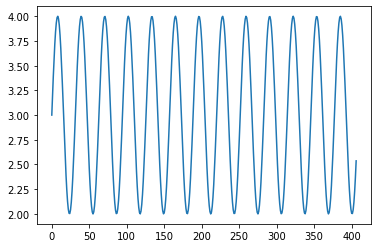

In [4]:
toy_data = []
for i in range(num_observations):
  val = np.sin(i/5)+3
  toy_data.append(val)

plt.plot(toy_data)
plt.show()

In [5]:
#observed_daily_hospit = torch.tensor(toy_data, requires_grad=False, device=device, dtype=dtype)

In [6]:
data = pd.read_csv('covid19model.csv')
observed_daily_hospit = torch.tensor(data.hospit, requires_grad=False, device=device, dtype=dtype)

In [7]:
phi_prime = torch.tensor(bij_transform_inv(torch.tensor(25), 0, 50), requires_grad=True, device=device, dtype=dtype)
sigma_prime = torch.tensor(bij_transform_inv(torch.tensor(0.1), 0.00001, 0.5), requires_grad=True, device=device, dtype=dtype)
sigma = bij_transform(sigma_prime, 0.00001, 0.5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [8]:
epsilon_t = torch.zeros(num_observations, device=device)
epsilon_t[0] = torch.distributions.Normal(cero, sigma.detach()).rsample()
for t in range(1, num_observations):
    epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].detach(), sigma.detach()).rsample()
epsilon_t.requires_grad_(True)

tensor([ 0.1292,  0.1704,  0.1250,  0.1132,  0.0809,  0.1649,  0.1402,  0.2117,
         0.2617,  0.4092,  0.4209,  0.3795,  0.4026,  0.3580,  0.1548,  0.0291,
        -0.0218,  0.1714,  0.1210,  0.2158,  0.1463,  0.1259,  0.1153, -0.1239,
        -0.0468,  0.0607,  0.0519,  0.0572,  0.0421,  0.0168,  0.0278,  0.0178,
        -0.0530,  0.0166, -0.0655, -0.0589,  0.0756,  0.0537,  0.0313,  0.0331,
        -0.1329, -0.0562, -0.1697, -0.1838, -0.2459, -0.1658, -0.1180, -0.1248,
        -0.1352, -0.1613, -0.1817, -0.0845, -0.0714,  0.0514,  0.2820,  0.2691,
         0.4272,  0.5035,  0.5501,  0.5085,  0.5378,  0.3877,  0.3292,  0.2486,
         0.3875,  0.3701,  0.3825,  0.4484,  0.4252,  0.5379,  0.6526,  0.6443,
         0.5781,  0.7460,  0.5380,  0.4237,  0.5768,  0.5335,  0.4241,  0.4346,
         0.2358,  0.1508,  0.1368,  0.2302,  0.2580,  0.2855,  0.0034, -0.0794,
        -0.0353, -0.2023, -0.2777, -0.3183, -0.3272, -0.3727, -0.2491, -0.5142,
        -0.5934, -0.3794, -0.3478, -0.17

In [9]:
def calc_random_walk_loss(epsilon_t, sigma):
    ll = torch.tensor(0.)
    loc = epsilon_t[:-1]
    scale = sigma * torch.ones(num_observations - 1)
    mvn = distributions.multivariate_normal.MultivariateNormal(loc, scale_tril=torch.diag(scale))
    ll += mvn.log_prob(epsilon_t[1:])
    return ll

In [10]:
def calc_mse(epsilon_t, observed_daily_hospit):
    diff = epsilon_t - observed_daily_hospit
    square = diff.square()
    msr = square.mean()
    return msr

In [11]:
def calc_neg_bin(expected_daily_hospit, observed_daily_hospit, phi):
    # compare observed hospitalizations to model results
    # likelihood of the data wrt. to the model
    ll = torch.tensor(0.)

    for i in range(0, num_observations):
        p = 1 / (1 + expected_daily_hospit[i].abs() / phi) # To Do: delete .abs() once we use real predictions
        #if p == 1:
        #    p = p.clone() - torch.tensor(2.225e-5)
        #if p < 2.225e-5:
        #    p = p.clone() + torch.tensor(2.225e-5)
        dist = torch.distributions.negative_binomial.NegativeBinomial(phi, p - torch.tensor(2.225e-5))
        ll += dist.log_prob(observed_daily_hospit[i])

    ll = (-1) * ll
    return ll

In [12]:
def calc_neg_bin_fast(expected_daily_hospit, observed_daily_hospit, phi):
  ll = torch.tensor(0.)
  p = 1 / (1 + expected_daily_hospit.abs()/ phi)
  dist = torch.distributions.negative_binomial.NegativeBinomial(phi, p)
  ll = dist.log_prob(observed_daily_hospit).sum()

  ll = (-1) * ll
  return ll

In [13]:
def forward_pass(epsilon_t, sigma_prime, phi_prime):
    sigma = bij_transform(sigma_prime, lower=0.00001, upper=0.5)
    phi = bij_transform(phi_prime, lower=0.00001, upper=50)

    #Calc Rt
    # Initialize eta_t
    eta_t = torch.zeros(num_observations, device=device)  # transformed reproduction number
    # calculate Rt: the basic reproduction number
    # basic reproduction number as a latent random walk
    beta_0 = torch.log(torch.tensor(3.6))
    eta_t[0] = beta_0
    eta_t[1:num_observations] = epsilon_t[0:num_observations - 1] + beta_0
    Rt = torch.exp(eta_t)

    return Rt, sigma, phi

In [14]:
sigma_vis = []
phi_vis = []

comp_loss_vis = []
rw_loss_vis = []

optimizer = optim.Adam([epsilon_t, sigma_prime, phi_prime], lr=0.01) #, phi_prime

for i in range(15000):
    start_time = time.time()
    optimizer.zero_grad()
    # forward pass
    expected_daily_hospit, sigma, phi = forward_pass(epsilon_t, sigma_prime, phi_prime)


    # calc loss
    rw_loss = 1e-13 * calc_random_walk_loss(epsilon_t, sigma)
    #comp_loss = 1e-1 * calc_neg_bin_fast(expected_daily_hospit, observed_daily_hospit, phi)
    comp_loss = calc_mse(expected_daily_hospit, observed_daily_hospit)


    loss = comp_loss + rw_loss

    # backward pass
    loss.backward()

    optimizer.step()

    # Visualisatzion
    sigma_vis.append(sigma.item())
    phi_vis.append(phi.item())
    comp_loss_vis.append(comp_loss.item())
    rw_loss_vis.append(rw_loss.item())

    if i % 100==0:
      print(f'Step: {i}')
      print("This Run:  %s seconds" % (time.time() - start_time))

Step: 0
This Run:  0.027581453323364258 seconds
Step: 100
This Run:  0.004739999771118164 seconds
Step: 200
This Run:  0.006834268569946289 seconds
Step: 300
This Run:  0.0054972171783447266 seconds
Step: 400
This Run:  0.003916263580322266 seconds
Step: 500
This Run:  0.003893136978149414 seconds
Step: 600
This Run:  0.0038890838623046875 seconds
Step: 700
This Run:  0.003874540328979492 seconds
Step: 800
This Run:  0.0038030147552490234 seconds
Step: 900
This Run:  0.003941059112548828 seconds
Step: 1000
This Run:  0.003935575485229492 seconds
Step: 1100
This Run:  0.004030942916870117 seconds
Step: 1200
This Run:  0.0038514137268066406 seconds
Step: 1300
This Run:  0.004045248031616211 seconds
Step: 1400
This Run:  0.0040585994720458984 seconds
Step: 1500
This Run:  0.003982067108154297 seconds
Step: 1600
This Run:  0.00424504280090332 seconds
Step: 1700
This Run:  0.003772258758544922 seconds
Step: 1800
This Run:  0.0044918060302734375 seconds
Step: 1900
This Run:  0.00376915931701

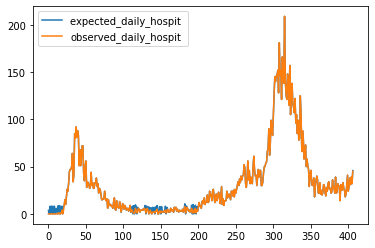

In [15]:
plt.plot(expected_daily_hospit.detach().numpy(), label='expected_daily_hospit ')
plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit')
plt.legend()
plt.show()

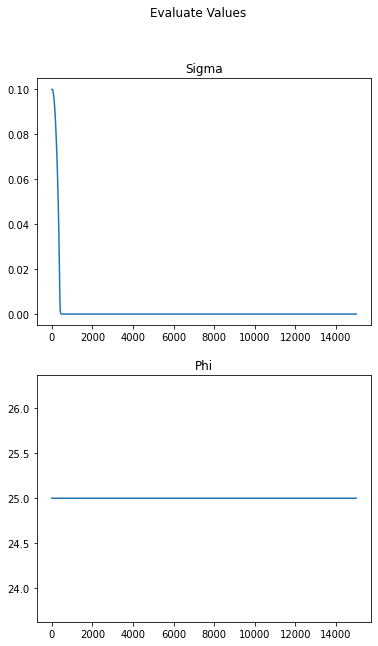

In [16]:
fig, axs = plt.subplots(2)
fig.suptitle(f'Evaluate Values')
fig.set_figheight(10)
axs[0].plot(sigma_vis)
axs[0].title.set_text('Sigma')
axs[1].plot(phi_vis)
axs[1].title.set_text('Phi')
plt.show()

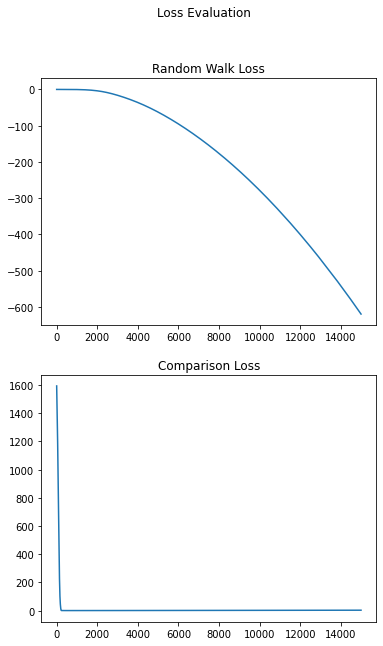

In [17]:
fig, axs = plt.subplots(2)
fig.suptitle(f'Loss Evaluation')
fig.set_figheight(10)
axs[0].title.set_text('Random Walk Loss')
axs[0].plot(rw_loss_vis)
axs[1].title.set_text('Comparison Loss')
axs[1].plot(comp_loss_vis)
plt.show()